Base for this notebook: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
Got the derivatives from: https://www.geeksforgeeks.org/lstm-derivation-of-back-propagation-through-time/

In [263]:
import numpy as np
import random as rd
from keras.datasets import mnist



In [265]:
def sigmoid(n: float):
    return 1.0/(1.0+np.exp(-n))

def sigmoid_derivative(n: float):
    """Derivative of the sigmoid function."""
    return sigmoid(n)*(1-sigmoid(n))
    

In [ ]:
class LSTM:
    """
    h = array of outputs
    x = array of inputs
    """
    
    
    def __init__(self, nInputs, nCells, nOutputs, batchSize):
        nGates = 4
        if nCells < nOutputs:
            print('the number of cells cannot be less than the number of outputs')
        
        x = np.zeros([batchSize, nInputs])
        h = np.zeros([batchSize, nInputs])
        w = []
        b = []
        nCells = layers[l]
        wScale = 1/np.sqrt(nCells*nGates)
        w.append(np.random.normal(loc=0,scale=wScale,size=[nCells, nGates, batchSize]))
        b.append(np.random.normal(loc=0,scale=1,size=[nCells, nGates, batchSize]))
        # The weight and bias is the same in every cell
        # w[i][j]: i = which gate, j = which batch
        # b[i][j]: i = which gate, j = which batch
        self.x = x
        self.h = h
        self.w = w
        self.b = b
        self.nCells = nCells
        
    def forgetGate(i, j, t):
        return sigmoid(self.w[i][j][0]*np.concatenate(self.h[t-1], self.x[t]) + self.b[i][j][0])
    
    def inputGate(i, j, t):
        i_t = sigmoid(self.w[i][j][1]*np.concatenate(self.h[t-1], self.x[t]) + self.b[i][j][1])
        C_t = tanh(self.w[i][j][2]*np.concatenate(self.h[t-1], self.x[t]) + self.b[i][j][2])        
        return i_t*C_t
    
    def outputGate(i, j, t, newC):
        sigmoid(self.w[i][j][3]*np.concatenate(self.h[t-1], self.x[t]) + self.b[i][j][3])
        h_t = o_t*tanh(newC)
        return h_t
      
    def getNewState(i, j, t, previousC, previousH, xElement):
        newC = previousC*forgetGate(i, j, t)
        newC = newC + inputGate(i, j, t)
        newH = outputGate(i, j, t, newC)
        return newC, newH
                             
    def setInput(lstm: LSTM, x):
        C = 0
        for t in range(self.Inputs):
            self.x[t] = x[t]
            C, self.h[t] = getNewState(C, self.h[t-1], x[t])
        return 
    
   
    def backProp():
        deltaOut = 0
        # a = C~, state = C
        for t in range(nCells, 0, -1):
            delta = h[t] - y[t]
            deltaOut[t] = delta + deltaOut
            deltaState[t] = deltaOut*o[t]*(1 - tanh(C[t])**2) + deltaState[t+1]*f[t+1]
            deltaA[t] = deltaState[t]*i[t]*(1 - a[t]**2)
            deltaI[t] = deltaState[t]*a[t]*i[t]*(1 - i[t])
            deltaF[t] = deltaState[t]*C[t-1]*f[t]*(1 - f[t])
            deltaO[t] = deltaOut[t]*tanh(C[t])*o[t]*(1 - o[t])
            deltaGates[t] = np.array([deltaA[t], deltaI[t], deltaF[t], deltaO[t]])
            deltaX[t] = np.dot(np.transpose(self.w), deltaGates[t])
            deltaX[t] = np.dot(np.transpose(self.u), deltaGates[t])
        
        deltaW = 0
        deltaU = 0
        deltaB = 0
        for t in range(nInputs):
            deltaW += np.outer(deltaGates[t], self.x[t])
            deltaB += deltaGates[t]
            deltaU += np.outer(deltaGates[t+1], self.h[t])
        return deltaW, deltaU, deltaB            
        
    def backwardPass(C):
        for t in range():
            C = h[t]*tahn(C)
            o[t]     
        return
              
                 
    def SGD(net: Network, X: list, y: list, batchSize: int, nEpochs: int, learningRate, lamb, earlyStop=False) -> Network:
    """
    Implementation of Stochastic Gradient Descent
    
    It takes as input the network, the MNIST dataset, the MNIST labels of the dataset, 
    the size of the batch to do gradient descent, the number of epochs it should run,
    the learning rate eta (I found the best eta to be in the order of 1s)
    and the regularization term lambda
    
    It returns a trained network
    """
    bestAcc = 0
    bestEpoch = 0
    earlyNet = net
    eta = learningRate
    etaChangeEpoch = 0
    for epoch in range(nEpochs):
        batch = rd.sample(range(len(X)), batchSize)
        nablaB = [np.zeros(i.shape) for i in net.b]
        nablaW = [np.zeros(i.shape) for i in net.w]
        for i in batch:
            net = setInput(net, X[i])
            # finding what should be modified based on this particular example
            deltaNablaB, deltaNablaW = LSTM.backProp(net, y[i])
            # passing this modifications to our overall modifications matrices
            for l in range(net.nLayers-1):
                nablaB[l] += deltaNablaB[l]
                nablaW[l] += deltaNablaW[l]
        
        # applying the changes to our network
        net.b = net.b - eta * (nablaB/batchSize) 
        net.w[l] = net.w - eta * (nablaW/batchSize) - eta * (lamb/batchSize) *  net.w
        acc, outputs = testNetwork(net, X, y, nTests=batchSize)
        if acc > bestAcc:
            bestAcc = acc
            bestEpoch = epoch
            earlyNet = LSTM.copy(net)
        print(f'learningRate: {learningRate} epochs: {epoch} acc: {acc}, outputs: {outputs}')
    print(f'best acc: {bestAcc} on epoch: {bestEpoch}')
    if earlyStop:
        return earlyNet
    return net

In [268]:
def testNetwork(net: Network, test_X, test_y, nTests: int):
    """
    A function to test our network
    
    It returns the overall accuracy and the numbers our network guessed
    """
    
    correctOutput = 0
    X = test_X[:nTests]
    y = test_y[:nTests]
    outputs = np.zeros(10)
    for i in range(nTests):
        net = setInput(net, X[i])
        networkOutput = np.argmax(net.a[-1])
        outputs[networkOutput] += 1
        #print(f"number: {y[i]}, networkOutput: {networkOutput}, activations: {net.a[-1]}")
        if y[i] == networkOutput:
            correctOutput += 1
    acc = correctOutput/nTests
    return acc, outputs


In [269]:
def gridSearch(net: Network, train_X, train_y, test_X, test_y, batchSize: int, learningRates: list, epochs: int, lamb):
    """
    A function to perform a gridSearch in order to find the best learningRates

    It takes as input the network, the training images of MNIST, the training labels,
    the test images, the test labels, the batchSize for SGD,
    a list of learningRates as to find the best inside the list
    the number of epochs to perform SGD
    
    
    It returns the best network accross all learning rates list
    """
    bestNet = net
    bestAcc = 0
    for eta in learningRates:
        # resetting the network
        net = Network([784,30,10])
        net = SGD(net, train_X, train_y, batchSize=batchSize, nEpochs=epochs, learningRate=eta, lamb=lamb)
        acc, outputs = testNetwork(net, test_X, test_y, batchSize) 
        if acc > bestAcc:
            bestNet = net
            bestAcc = acc
    return bestNet


The list below is all equations that were used to compute the erros and then propagate through the network:

To calculate the error on the last layer: 
$$\delta^L = (a^L - y)\odot \sigma'(z^L)$$

To calculate the error on the other layers:
$$\delta^l = ((w^{l+1})^T\delta^{l+1})\odot \sigma'(z^l)$$

To repass the error to the bias: 
$$\frac{\partial C}{\partial b^l_j} = \delta^l_j$$

To repass the error to the weights:
$$\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k\delta^l_j$$

In [270]:
def backProp(net: Network, y) -> Network:
    """
    The backpropagation step: first we calculate the error on the last layer, 
    then we pass to the previous layers all the while applying the error 
    to the weights and biases. Here we used Cross-entropy as our cost function
    
    Example on a 3 layer network: We calculate the error on the last layer, 
    apply it to the last layer's weights and biases, and then calculate the 
    error on the next layer, propagate to the weights and biases and it's done
    
    It takes as input the network and the label of the number the network was activated on
    
    It returns the modifications to the weights and biases (nablaW and nablaB) 
    the network should have
    """
    layers = net.layers
    nablaB = [np.zeros(i.shape) for i in net.b]
    nablaW = [np.zeros(i.shape) for i in net.w]
    delta = np.zeros(10) # 10 because its the possible number of outputs
    for j in range(net.layers[-1]):
        if y == j:
            delta[j] += (net.a[-1][j] - 1)
        else:
            delta[j] += (net.a[-1][j] - 0)
    for l in range(net.nLayers-1, 0, -1):
        #nablaB and nablaW have -1 because they only have 2 layers instead of 3
        nablaB[l-1] = delta
                
        for j in range(layers[l]):
            for k in range(layers[l-1]):
                nablaW[l-1][k][j] += net.a[l-1][k]*delta[j]
        
        # finding the error one layer behind
        # in the book it needs a transpose because its weight[layer][receivingNeuron][givingNeuron]
        # but my implementation uses weight[layer][givingNeuron][receivingNeuron] so it's not necessary
        delta = (np.dot(net.w[l-1], delta))*sigmoid_derivative(net.z[l-1])
        
    return nablaB, nablaW


In [271]:
def SGD(net: Network, X: list, y: list, batchSize: int, nEpochs: int, learningRate, lamb, earlyStop=False) -> Network:
    """
    Implementation of Stochastic Gradient Descent
    
    It takes as input the network, the MNIST dataset, the MNIST labels of the dataset, 
    the size of the batch to do gradient descent, the number of epochs it should run,
    the learning rate eta (I found the best eta to be in the order of 1s)
    and the regularization term lambda
    
    It returns a trained network
    """
    bestAcc = 0
    bestEpoch = 0
    earlyNet = net
    eta = learningRate
    etaChangeEpoch = 0
    for epoch in range(nEpochs):
        batch = rd.sample(range(len(X)), batchSize)
        nablaB = [np.zeros(i.shape) for i in net.b]
        nablaW = [np.zeros(i.shape) for i in net.w]
        for i in batch:
            net = setInput(net, X[i])
            # finding what should be modified based on this particular example
            deltaNablaB, deltaNablaW = backProp(net, y[i])
            # passing this modifications to our overall modifications matrices
            for l in range(net.nLayers-1):
                nablaB[l] += deltaNablaB[l]
                nablaW[l] += deltaNablaW[l]
        
        # applying the changes to our network
        for l in range(net.nLayers-1):
            net.b[l] = net.b[l] - eta * (nablaB[l]/batchSize) 
            net.w[l] = net.w[l] - eta * (nablaW[l]/batchSize) - eta * (lamb/batchSize) *  net.w[l]
        acc, outputs = testNetwork(net, X, y, nTests=batchSize)
        if acc > bestAcc:
            bestAcc = acc
            bestEpoch = epoch
            earlyNet = net
            etaChangeEpoch = epoch
        print(f'learningRate: {learningRate} epochs: {epoch} acc: {acc}, outputs: {outputs}')
    print(f'best acc: {bestAcc} on epoch: {bestEpoch}')
    if earlyStop:
        return earlyNet
    return net
        

In [272]:
# initializing the network and the dataset

net = Network([784,30,10])
(train_X, train_y), (test_X, test_y) = mnist.load_data()



In [273]:
net = gridSearch(net, train_X, train_y, test_X, test_y, batchSize=100, learningRates=[1.6], epochs=200, lamb=0)

learningRate: 2 epochs: 0 acc: 0.1, outputs: [ 0.  0. 10.  0.  0.  0.  0.  0.  0.  0.]
learningRate: 2 epochs: 1 acc: 0.0, outputs: [0. 0. 0. 0. 0. 6. 0. 4. 0. 0.]
learningRate: 2 epochs: 2 acc: 0.1, outputs: [ 0.  0. 10.  0.  0.  0.  0.  0.  0.  0.]
learningRate: 2 epochs: 3 acc: 0.0, outputs: [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]
learningRate: 2 epochs: 4 acc: 0.0, outputs: [ 0.  0.  0.  0.  0.  0.  0. 10.  0.  0.]
learningRate: 2 epochs: 5 acc: 0.1, outputs: [0. 0. 0. 0. 6. 0. 0. 0. 4. 0.]
learningRate: 2 epochs: 6 acc: 0.1, outputs: [0. 0. 0. 0. 2. 0. 0. 0. 8. 0.]
learningRate: 2 epochs: 7 acc: 0.1, outputs: [10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
learningRate: 2 epochs: 8 acc: 0.3, outputs: [0. 1. 0. 0. 9. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 9 acc: 0.1, outputs: [8. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
learningRate: 2 epochs: 10 acc: 0.2, outputs: [ 0.  0.  0.  0. 10.  0.  0.  0.  0.  0.]
learningRate: 2 epochs: 11 acc: 0.2, outputs: [0. 2. 0. 0. 0. 0. 0. 3. 5. 0.]
learningRate: 

learningRate: 2 epochs: 105 acc: 1.0, outputs: [1. 3. 1. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 106 acc: 1.0, outputs: [1. 3. 1. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 107 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 108 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 109 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 110 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 111 acc: 0.6, outputs: [1. 1. 3. 2. 2. 0. 0. 1. 0. 0.]
learningRate: 2 epochs: 112 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 113 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 114 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 115 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 116 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 117 acc: 0.8, outputs: [1. 3

In [274]:
testNetwork(net, test_X, test_y, len(test_X))

(0.7948,
 array([ 892., 1165.,  616., 1402.,  804.,  513., 1151., 1287.,  949.,
        1221.]))

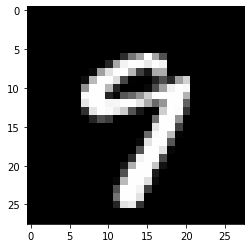

7

In [275]:
# Seeing our network in action

import matplotlib.pyplot as plt

# pick a sample to plot
sample = 50099
image = train_X[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

net = setInput(net, train_X[sample])
networkOutput = np.argmax(net.a[-1])
networkOutput